# Exercise 3 | TKO_2096 Applications of Data Analysis 2021
## deadline: 22.2.2021, 23:59 pm

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Tomi Salomaa

Student number: 

Student email: 

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=7 (7NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 7-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 7NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 for help). Estimate the water permeability prediction performance (using 7NN model and C-index) with the following distance parameter values: d = 0, 10, 20, ..., 200 (that is, 10 meter intervals from 0m to 200m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. Remember to also take advantage of earlier exercises (e.g. C-index). For the 7-nearest neighbor and Euclidean distance calculation you can use third-party libraries (e.g. Scikit-learn) if you want.  


- Plot of the graph C-index vs. distance parameter value. 


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [1]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from google.colab import files
from sklearn.neighbors import KNeighborsRegressor

uploaded = files.upload()

Saving input.csv to input.csv
Saving output.csv to output.csv
Saving coordinates.csv to coordinates.csv


### Read in the datasets

In [2]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).
#
# Note that the coordinates are in EUREF-TM35FIN format, so you 
# can use the Euclidean distance to calculate the distance between two coordinate points.

coord_data = pd.read_csv('coordinates.csv',header=None)
input_data = pd.read_csv('input.csv',header=None)
output_data = pd.read_csv('output.csv',header=None)

print('COORDINATES DATASET')
print('-'*35)
print('\nShape:',coord_data.shape)
print('\nHas null values:',coord_data.isnull().values.any())
print('\nSample:')
print(coord_data.sample(5))

print('\nINPUT DATASET')
print('-'*35)
print('\nShape:',input_data.shape)
print('\nHas null values:',input_data.isnull().values.any())
print('\nSample:')
print(input_data.sample(5))

print('\nOUTPUT DATASET')
print('-'*35)
print('\nShape:',output_data.shape)
print('\nHas null values:',output_data.isnull().values.any())
print('\nSample:')
print(output_data.sample(5))

COORDINATES DATASET
-----------------------------------

Shape: (1691, 2)

Has null values: False

Sample:
             0          1
283   465550.0  7529900.0
1263  495140.0  7536500.0
886   487040.0  7525500.0
5     462200.0  7547400.0
113   464550.0  7541100.0

INPUT DATASET
-----------------------------------

Shape: (1691, 75)

Has null values: False

Sample:
           0         1         2   ...        72        73        74
948  0.450663  1.134635  0.758656  ... -1.826523  1.025800 -0.368280
714 -0.503453 -0.422996  0.015343  ... -0.223620  1.019510 -0.788681
633 -0.578496 -0.581564  0.210020  ...  1.273535  1.692548 -0.778514
147 -0.857226 -0.832834  1.537365  ...  0.784819  0.635816 -0.027099
377 -0.857226 -0.832834  0.634771  ...  0.072221  1.960925  0.599101

[5 rows x 75 columns]

OUTPUT DATASET
-----------------------------------

Shape: (1691, 1)

Has null values: False

Sample:
           0
651   5.9733
124   6.3298
990   6.5147
247   7.0549
1387  6.9690


### Standardization of the predictor features (input.csv)

In [3]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 

def df_z_standardizer(df):
    standardized_df = df.copy()
    for column in standardized_df.columns:
        standardized_df[column] = (standardized_df[column] -
                                   standardized_df[column].mean()) / standardized_df[column].std()
    return standardized_df

z_input = df_z_standardizer(input_data)
print('Sample of z-standardized input dataset:\n')
print(z_input.sample(5))

Sample of z-standardized input dataset:

            0         1         2   ...        72        73        74
309  -0.856973 -0.832588  0.581505  ... -0.598490 -0.810661  1.070896
1249 -0.599759 -0.719184 -0.869296  ... -0.790212 -0.718434 -0.332269
1086  1.918790  1.392812 -0.993145  ... -1.688930 -0.783412  1.311616
590  -0.781952 -0.771618 -1.577004  ... -0.766794 -0.754067 -2.164708
1213  1.190018  1.340378 -1.010838  ...  0.026123 -0.768740 -1.022942

[5 rows x 75 columns]


### Functions

In [7]:
# Include here all the functions (for example the C-index-function) that you need in order to implement the task.

# Build a new dataframe with all the labels, features and coords
data_x_y_c = pd.concat([output_data,z_input,coord_data],ignore_index=True,axis=1)

# CINDEX
def cindex(true, pred, regression=False,silent=False):
  n = 0
  n_total = 0
  pairs = list()
  neg_pairs = list()
  pos_pairs = list()

  # Create true,prediction -pairs
  for i in range(len(true)):
    pairs.append([true[i],pred[i]])
  
  if not regression:
    # works for binary labels
    for i in range(len(pairs)):
      if pairs[i][0] != 1:
        neg_pairs.append(pairs[i])
      else:
        pos_pairs.append(pairs[i])
    for i in range(len(neg_pairs)):
      for j in range(len(pos_pairs)):
        test_one = neg_pairs[i][0]>pos_pairs[j][0]
        test_two = neg_pairs[i][1]>pos_pairs[j][1]
        test_three = neg_pairs[i][1]==pos_pairs[j][1]

        if test_one == test_two:
          n += 1
          if test_three:
            n -= 0.5
        n_total += 1
  else:
    # this should apply to regression cases
    for i in range(len(pairs)-1):
      for j in range(i+1,len(pairs)):
        if pairs[i][0] != pairs[j][0]:
          test_one = pairs[i][0]<pairs[j][0]
          test_two = pairs[i][1]<pairs[j][1]
          test_three = pairs[i][1]==pairs[j][1]

          if test_one == test_two:
            n += 1
            if test_three:
              n -= 0.5
          n_total += 1

  cindx = n / n_total

  if not silent:
    print('CONCORDANCE INDEX RESULTS')
    print('-'*35)
    print('Total number of input pairs:',len(pairs))
    print('N:',n)
    print('N total:',n_total)
    print('C-INDEX:',cindx)
  
  return cindx

# Leave-One-Out Spatial K-fold Cross Validation
#
# Step 1: Loop the dataset for k (folds) and perform steps 2-4
# Step 2: Choose a test point / set within fold and remove closest data points (determined by distance range).
# Step 3: Build the model with the reduced training set (excludes the removed data points and the test point / set).
# Step 4: Make predictions with the test point / set.
# Step 5: Calculate mean prediction accuracy.
# Step 6: Return mean prediction accuracy.
def LOO_SKCV(dataset,dist,neighbours_n=7):

  folds = list(dataset.values)
  cindex_arr = list()
  predictions = list()
  true_labels = list()
  knn = KNeighborsRegressor(n_neighbors = neighbours_n)

  # Splitting folds and data -- in this case iterating the dataset
  for i in range(len(folds)):
    # Fit with all but the index
    train_set_raw = list(folds)
    train_set_picked = list()
    test_set = train_set_raw.pop(i)

    test_set_coords = np.array(([test_set[76],test_set[77]]))

    for j in range(len(train_set_raw)):
      train_set_coords = np.array(([train_set_raw[j][76],train_set_raw[j][77]]))
      point_distance = np.linalg.norm(test_set_coords - train_set_coords)
      if point_distance > dist:
        train_set_picked.append(train_set_raw[j])


    y_train = [arr[:1] for arr in train_set_picked]
    x_train = [arr[1:76] for arr in train_set_picked]
    
    knn.fit(x_train, y_train)

    # Test arrays
    y_test = np.array([test_set[0]])
    x_test = np.array(test_set[1:76])
    true_labels.append(y_test)
    
    # Predict
    pred = knn.predict(x_test.reshape(1,-1))
    predictions.append(pred)

  # Calculate mean CINDEX
  acc_cindex = np.around(cindex(true_labels,predictions,True,True), decimals=5)

  print('LOO_SKCV RESULTS')
  print('-'*42)
  print('CINDEX SCORE:',acc_cindex)
  print('-'*42)

  return acc_cindex

### Results for spatial leave-one-out cross-validation with 7-nearest neighbor regression model

MODEL PERFORMANCE WITH DISTANCE 0
Processing...
LOO_SKCV RESULTS
------------------------------------------
CINDEX SCORE: 0.71498
------------------------------------------
MODEL PERFORMANCE WITH DISTANCE 10
Processing...
LOO_SKCV RESULTS
------------------------------------------
CINDEX SCORE: 0.70739
------------------------------------------
MODEL PERFORMANCE WITH DISTANCE 20
Processing...
LOO_SKCV RESULTS
------------------------------------------
CINDEX SCORE: 0.70611
------------------------------------------
MODEL PERFORMANCE WITH DISTANCE 30
Processing...
LOO_SKCV RESULTS
------------------------------------------
CINDEX SCORE: 0.70316
------------------------------------------
MODEL PERFORMANCE WITH DISTANCE 40
Processing...
LOO_SKCV RESULTS
------------------------------------------
CINDEX SCORE: 0.70039
------------------------------------------
MODEL PERFORMANCE WITH DISTANCE 50
Processing...
LOO_SKCV RESULTS
------------------------------------------
CINDEX SCORE: 0.69506


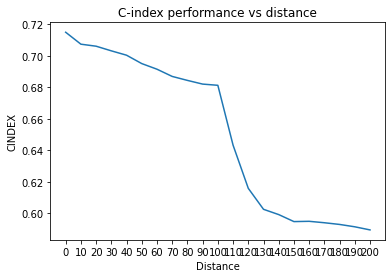

<Figure size 720x288 with 0 Axes>

In [8]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 7-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.
cindex_results = list()
used_distances = list()

used_distance = 0

while used_distance < 201:
  print('MODEL PERFORMANCE WITH DISTANCE',used_distance)
  print('Processing...')
  c_result = LOO_SKCV(data_x_y_c,used_distance)
  cindex_results.append(c_result)
  used_distances.append(used_distance)
  used_distance += 10

plt.plot(used_distances,cindex_results)
plt.xticks(np.arange(0,201,10))
plt.title('C-index performance vs distance')
plt.xlabel('Distance')
plt.ylabel('CINDEX')
fig = plt.figure() 
fig.set_figwidth(10)
plt.show()

### Interpretation of the results

In [ ]:
# In this cell, give a brief commentary on the results, what happens to the prediction 
# performance as the prediction distance increases?

Overall the range of prediction accuracy ranges from ~0.71 to ~0.59.
The model performs better when predicting with distances below 100 but then ends up decreasing relatively sharply as the distance grows from 100 to around 125. The performance keeps declining as the distance grows.

The observations seem to be quite in sync with the lecture materials where the forestry machine example used demonstrated a similar pattern.